In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer

In [126]:
filePath_train = 'dmoz_links_train.csv'
filePath_test ='dmoz_links_test.csv'
all_train_data = pd.read_csv(filePath_train)
all_test_data =pd.read_csv(filePath_test)

In [127]:
categories =['','health', 'education', 'Agriculture', 'technology', 'transport',
       'climate/environment', 'finance']

In [128]:
all_train_data.groupby(['category']).count()

,link,title,description
category,,,
Agriculture,5419,5419,5419
climate/environment,3995,3995,3995
education,14613,14613,14613
finance,457,457,457
health,34975,34975,34974
technology,6280,6280,6280
transport,6849,6849,6849


#### create a new data frame with a less skewed category counts, size of 4k per category


In [129]:
all_test_data.groupby(['category']).count()

,link,title,description
category,,,
Agriculture,1369,1369,1369
climate/environment,997,997,997
education,3732,3732,3732
finance,129,129,129
health,8782,8782,8782
technology,1468,1468,1468
transport,1670,1670,1670


In [130]:
def balanceCategory(data, count=4000):
    tempItems =[]
    for x in categories[1:]:
        catItem = data.loc[data['category'] == x,:]
        tempItems.append(catItem.iloc[:count,:])
    result = pd.concat(tempItems)
    return result.sample(frac=1).reset_index(drop=True)

all_test_data = balanceCategory(all_test_data, 1000)
all_train_data = balanceCategory(all_train_data)


In [131]:

all_train_data['all_text'] = all_train_data['title'].str.cat(all_train_data['description'],sep=' ')
all_test_data['all_text'] = all_test_data['title'].str.cat(all_test_data['description'],sep=' ')


all_train_data = all_train_data.loc[pd.notna(all_train_data['all_text']),:]
all_test_data = all_test_data.loc[pd.notna(all_test_data['all_text']),:]

tempDt = pd.DataFrame()
tempDt['all_text'] = pd.concat([all_train_data['all_text'],
                                all_test_data['title']])
tempDt

,all_text
0,Mortgage Forum Post questions and receive answ...
1,American Windmills Home Page American Windmill...
2,Alternative Truths: Reiki Based in Ontario. Re...
3,Kagawa Nutrition University With undergraduate...
4,University of Gondar Information on Facilities...
...,...
6121,American Zoo and Aquarium Association
6122,Florida International University School of Hos...
6123,MedlinePlus Medical Encyclopedia: Brucellosis
6124,Constructivism: From Philosophy to Practice


In [132]:
english_stopwords = stopwords.words('english')

def tokenize_and_stem(item):
    exclude =' .,-\t\n_#}{\/][;'   
    item = item.lower().split()
    left = [x.lower() for x in item if x not in english_stopwords]
    left = [x.strip(exclude) for x in left if x and isinstance(x,str) and x.strip(exclude)]
    ps = PorterStemmer()
    result = [ps.stem(y) for y in left]
    return result

def getVectors(all_data):
    data = all_data
    doc = [x.lower().strip('., \t\n') for x in data['all_text'].values.tolist() if x and isinstance(x,str) and x.strip(' .,-\t\n')]
    model = TfidfVectorizer(strip_accents='ascii', tokenizer = tokenize_and_stem)
    result = model.fit(doc)
    return result


In [133]:
textModel = getVectors(tempDt)
textModel


/home/bamobravo/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(strip_accents='ascii',
                tokenizer=<function tokenize_and_stem at 0x7f993e631d80>)

### Build SVM classifier using TFIDF Features

In [134]:
# We have to build the training data, each will contain the tfidf of each of the work and the category

Y = all_train_data['category']
def textTransformer(item):
    item = str(item[-1])
    items = [item]
    result = textModel.transform(items)
    return result[0]


X_test = textModel.transform(cleanText(all_test_data['all_text'].values))
X_train = textModel.transform(cleanText(all_train_data['all_text'].values))
X_train

<24452x36398 sparse matrix of type '<class 'numpy.float64'>'
	with 350469 stored elements in Compressed Sparse Row format>

In [135]:

def getY(data):
    data['target']=0
    data.loc[data['category']=='health','target']=1
    data.loc[data['category']=='education','target']=2
    data.loc[data['category']=='Agriculture','target']=3
    data.loc[data['category']=='technology','target']=4
    data.loc[data['category']=='transport','target']=5
    data.loc[data['category']=='climate/environment','target']=6
    data.loc[data['category']=='finance','target']=7
    result = data['target']
    return result
    

In [136]:
Y_train = getY(all_train_data)
Y_test = getY(all_test_data)
Y_train.unique()

array([7, 4, 1, 2, 5, 3, 6])

### build SVM model for classification

In [137]:
from sklearn.svm import SVC, LinearSVC

In [138]:
svc = LinearSVC(C=0.5)
svc.fit(X_train, all_train_data['target'])

# newSVC = SVC(probability=True, verbose=True, max_iter=10000)
# newSVC.fit(X_train, all_train_data['target'])
# let change the model to a normal SVC and see how long that is going to take and the performance metrics for the model

/home/bamobravo/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=0.5)

In [139]:
# save the model later use
import pickle

with open('./svm_model.model','wb') as fl:
    pickle.dump(svc, fl)

with open('./text_model.vector','wb') as fl:
    pickle.dump(textModel,fl)

In [140]:
predicted = svc.predict(X_test)
np.unique(predicted)

array([1, 2, 3, 4, 5, 6, 7])

## Generate metrics and plots

In [141]:
from sklearn.metrics  import f1_score, accuracy_score, precision_score, recall_score

In [143]:
accuracy = accuracy_score(predicted,Y_test)
accuracy

0.9038524322559582

### The classification Needs to be binary for both SVM and TFIDF cosine distance

In [144]:
import random
def separateToCategory(data, categories, predictions):
    result ={}
    for index, category in enumerate(categories):
        data['temp_target'] = 0
        data['temp_predicted'] = predictions
        data.loc[data['category'] == category,'temp_target'] = 1
        data.loc[data['temp_predicted'] == (index+1),'temp_predicted'] = 1
        data.loc[data['temp_predicted'] > 1,'temp_predicted'] = 0
        result[category]=[data['temp_target'].values, data['temp_predicted'].values]
    return result
        

### Get the precision, recall and the f-measure metrics for each of the category

In [145]:
test_predicted = svc.predict(X_test)
category_test = separateToCategory(all_test_data, categories[1:], test_predicted)
category_prediction = {}
for key in category_test:
    tempValue = category_test[key]
    precision = precision_score(tempValue[0], tempValue[1])
    recall = recall_score(tempValue[0], tempValue[1])
    fscore = f1_score(tempValue[0], tempValue[1])
    category_prediction[key] = {'category':key,'precision':precision, 'recall':recall, 'f-measure':fscore}


In [146]:
predictionFrame = pd.DataFrame(category_prediction.values())
predictionFrame

,category,precision,recall,f-measure
0,health,0.921132,0.911000,0.916038
1,education,0.467429,0.940000,0.624377
2,Agriculture,0.461809,0.919000,0.614716
3,technology,0.442317,0.878000,0.588275
4,transport,0.472402,0.950000,0.631020
5,climate/environment,0.459432,0.908726,0.610307
6,finance,0.100726,0.860465,0.180341


### Building the TFIDF classifier using Cosine similarity score and threshold

<Axes: title={'center': 'Precision, Recall and F-measure Comparision Chart By Category For SVM Classifier'}, xlabel='Category', ylabel='Value'>

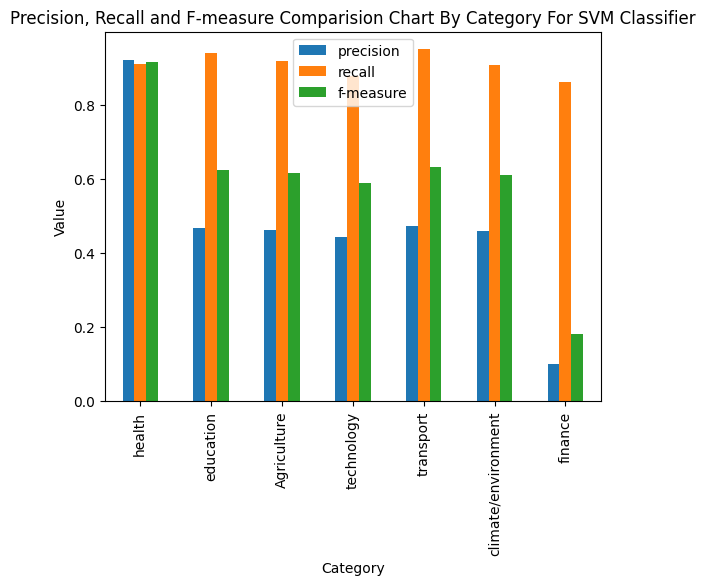

In [147]:
predictionFrame.plot(kind='bar', x='category', xlabel='Category', ylabel='Value', title='Precision, Recall and F-measure Comparision Chart By Category For SVM Classifier')

### Starting Metrics generation for TFIDF Cosine distance classifier

In [148]:
categoryVector = {}
for category in categories[1:]:
    all_text = ' '.join(all_train_data.loc[all_train_data['category']==category,'all_text'])
    vector = textModel.transform([all_text])
    categoryVector[category] = vector[0]

In [149]:

from scipy.spatial.distance import cosine as cosine_similarity
thresholds = {}
for category in categories[1:]:
    sub_train_data = all_train_data.loc[all_train_data['category']==category,'all_text'].values
    temp_vectors = textModel.transform(sub_train_data)
    main_vector = categoryVector[category]
    numpy_main_vector = main_vector.toarray()[0]
    temp_distance = [cosine_similarity(x.toarray()[0], numpy_main_vector)  for x in  temp_vectors]
    thresholds[category] = min(temp_distance)
thresholds


{'health': 0.6098490708610427,
 'education': 0.5479562492850392,
 'Agriculture': 0.625005630161594,
 'technology': 0.626308747047388,
 'transport': 0.5982461188646295,
 'climate/environment': 0.5198883549402236,
 'finance': 0.5650634800094061}

In [150]:
thresholdFrame = pd.DataFrame({'category':thresholds.keys(),'min_score':thresholds.values()})
thresholdFrame

,category,min_score
0,health,0.609849
1,education,0.547956
2,Agriculture,0.625006
3,technology,0.626309
4,transport,0.598246
5,climate/environment,0.519888
6,finance,0.565063


<Axes: title={'center': 'Charts of Minimum Value For Each Categories'}, xlabel='Category', ylabel='Min Values'>

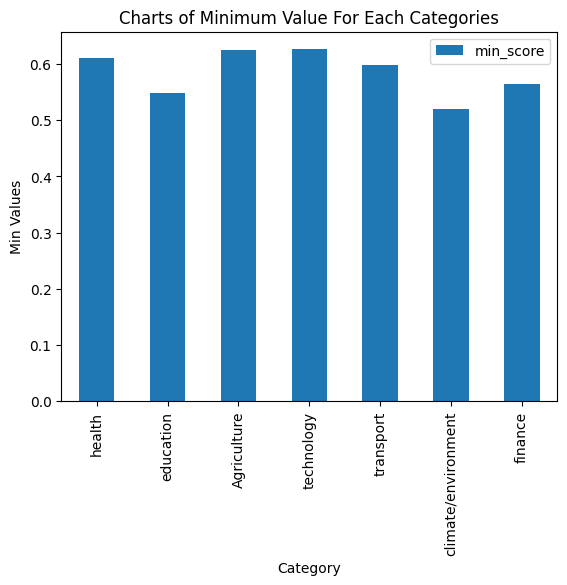

In [151]:
thresholdFrame.plot(kind='bar',x='category', title='Charts of Minimum Value For Each Categories', ylabel='Min Values',xlabel='Category')

In [157]:
# Now lets work on the predictions for the test data
predictions = {}
for category in categories[1:]:
    sub_test_data = all_test_data.loc[all_test_data['category'] == category,'all_text'].values
    temp_vectors = textModel.transform(sub_test_data)
    main_vector = categoryVector[category]
    numpy_main_vector = main_vector.toarray()[0]
    # minValue = 0.7
    minValue = thresholds[category]
    temp_distance = np.array([1 if cosine_similarity(x.toarray()[0], numpy_main_vector) >= minValue else 0  for x in  temp_vectors])
    predictions[category] = temp_distance


In [158]:
def predictVector(thresholds,test_data, categoryVector):
    sub_test_data = test_data['all_text'].values
    all_categories_temp = test_data['category'].values
    temp_vectors = textModel.transform(sub_test_data)
    threshold = 0.6
    temp_distance = np.array([1 if cosine_similarity( x.toarray()[0], categoryVector[all_categories_temp[i]].toarray()[0]) >= threshold else 0 for i,x in  enumerate(temp_vectors)])
    return temp_distance

In [162]:
vector_prediction = predictVector(thresholds,all_test_data,categoryVector)
np.unique(vector_prediction)

array([0, 1])

In [163]:
category_test_vector = separateToCategory(all_test_data, categories[1:], vector_prediction)
category_test_vector

{'health': [array([0, 1, 0, ..., 1, 0, 0]), array([1, 1, 1, ..., 1, 1, 1])],
 'education': [array([0, 0, 0, ..., 0, 1, 0]), array([1, 1, 1, ..., 1, 1, 1])],
 'Agriculture': [array([0, 0, 0, ..., 0, 0, 0]),
  array([1, 1, 1, ..., 1, 1, 1])],
 'technology': [array([0, 0, 0, ..., 0, 0, 0]),
  array([1, 1, 1, ..., 1, 1, 1])],
 'transport': [array([0, 0, 0, ..., 0, 0, 0]), array([1, 1, 1, ..., 1, 1, 1])],
 'climate/environment': [array([1, 0, 0, ..., 0, 0, 1]),
  array([1, 1, 1, ..., 1, 1, 1])],
 'finance': [array([0, 0, 1, ..., 0, 0, 0]), array([1, 1, 1, ..., 1, 1, 1])]}

In [164]:
category_prediction_vector = {}
for key in category_test_vector:
    tempValue = category_test_vector[key]
    precision = precision_score(tempValue[0], tempValue[1])
    recall = recall_score(tempValue[0], tempValue[1])
    fscore = f1_score(tempValue[0], tempValue[1])
    category_prediction_vector[key] = {'category':key,'precision':precision, 'recall':recall, 'f-measure':fscore}

category_prediction_vector

{'health': {'category': 'health',
  'precision': 0.16337199803953603,
  'recall': 1.0,
  'f-measure': 0.2808594298553574},
 'education': {'category': 'education',
  'precision': 0.16288188204541743,
  'recall': 0.997,
  'f-measure': 0.2800168515657913},
 'Agriculture': {'category': 'Agriculture',
  'precision': 0.16337199803953603,
  'recall': 1.0,
  'f-measure': 0.2808594298553574},
 'technology': {'category': 'technology',
  'precision': 0.16337199803953603,
  'recall': 1.0,
  'f-measure': 0.2808594298553574},
 'transport': {'category': 'transport',
  'precision': 0.16337199803953603,
  'recall': 1.0,
  'f-measure': 0.2808594298553574},
 'climate/environment': {'category': 'climate/environment',
  'precision': 0.1627185100473779,
  'recall': 0.9989969909729187,
  'f-measure': 0.2798538915425682},
 'finance': {'category': 'finance',
  'precision': 0.02091161574906061,
  'recall': 0.9922480620155039,
  'f-measure': 0.04096}}

#### Now perform comparision For the SVM classifier and the TFIDF classifier

##### Compare Precision for SVM and TFIDF

In [165]:
temp_precision = {'category': list(category_prediction_vector.keys()), 
                  'TFIDF':[category_prediction_vector[x]['precision'] for x in category_prediction_vector],
                  'SVM':[category_prediction[x]['precision'] for x in category_prediction]
                  }
precision_compare_frame = pd.DataFrame(temp_precision)
precision_compare_frame

,category,TFIDF,SVM
0,health,0.163372,0.921132
1,education,0.162882,0.467429
2,Agriculture,0.163372,0.461809
3,technology,0.163372,0.442317
4,transport,0.163372,0.472402
5,climate/environment,0.162719,0.459432
6,finance,0.020912,0.100726


<Axes: title={'center': 'Comparing TFIDF Precision with SVM Classifier'}, xlabel='Category', ylabel='Precision Score'>

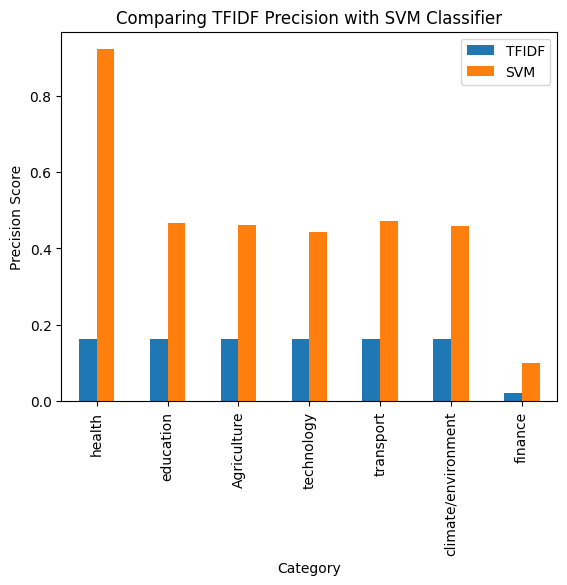

In [166]:
precision_compare_frame.plot(kind='bar', title="Comparing TFIDF Precision with SVM Classifier", x='category', xlabel="Category", ylabel='Precision Score')

##### Compare Recall for SVM and TFIDF

In [167]:
temp_recall = {'category': list(category_prediction_vector.keys()), 
                  'TDIDF':[category_prediction_vector[x]['recall'] for x in category_prediction_vector],
                  'SVM':[category_prediction[x]['recall'] for x in category_prediction]
                  }
recall_compare_frame = pd.DataFrame(temp_recall)
recall_compare_frame

,category,TDIDF,SVM
0,health,1.000000,0.911000
1,education,0.997000,0.940000
2,Agriculture,1.000000,0.919000
3,technology,1.000000,0.878000
4,transport,1.000000,0.950000
5,climate/environment,0.998997,0.908726
6,finance,0.992248,0.860465


<Axes: title={'center': 'Comparing TFIDF Recall with SVM Classifier'}, xlabel='Category', ylabel='Recall Score'>

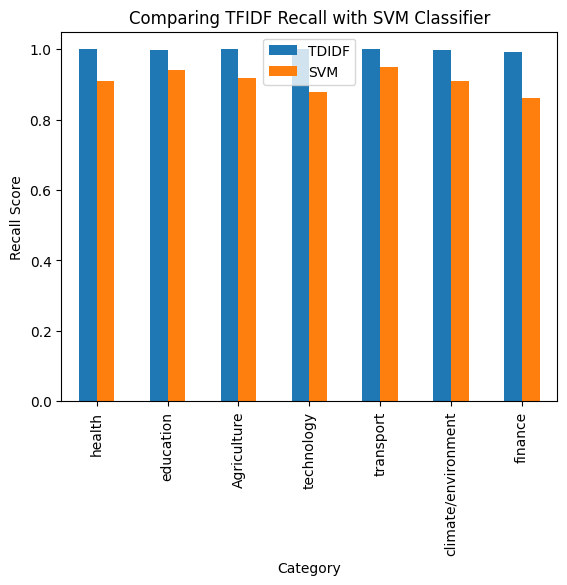

In [168]:
recall_compare_frame.plot(kind='bar', title="Comparing TFIDF Recall with SVM Classifier", x='category', xlabel="Category", ylabel='Recall Score')

##### Compare F-Measure for SVM and TFIDF

In [169]:
temp_fscore = {'category': list(category_prediction_vector.keys()), 
                  'TDIDF':[category_prediction_vector[x]['f-measure'] for x in category_prediction_vector],
                  'SVM':[category_prediction[x]['f-measure'] for x in category_prediction]
                  }
fscore_compare_frame = pd.DataFrame(temp_fscore)
fscore_compare_frame

,category,TDIDF,SVM
0,health,0.280859,0.916038
1,education,0.280017,0.624377
2,Agriculture,0.280859,0.614716
3,technology,0.280859,0.588275
4,transport,0.280859,0.631020
5,climate/environment,0.279854,0.610307
6,finance,0.040960,0.180341


<Axes: title={'center': 'Comparing TFIDF F-measure with SVM Classifier'}, xlabel='Category', ylabel='F-measure Score'>

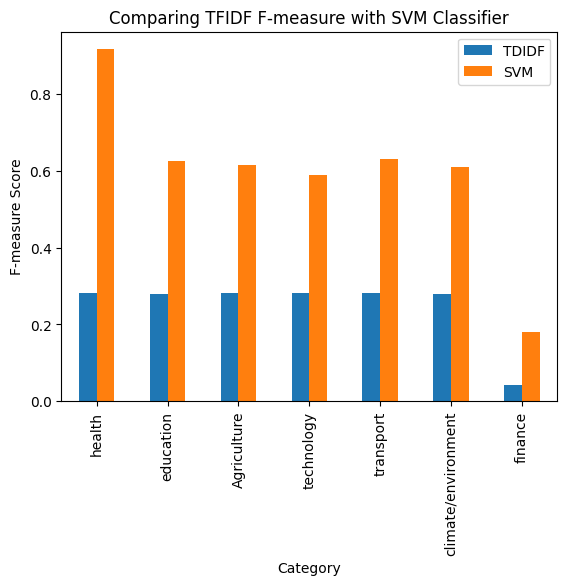

In [170]:
fscore_compare_frame.plot(kind='bar', title="Comparing TFIDF F-measure with SVM Classifier", x='category', xlabel="Category", ylabel='F-measure Score')